# Implementation and run with U-Net architecture

In [1]:
from __future__ import division, print_function
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib
import numpy as np

In [2]:
import os
import matplotlib.image as mpimg
import cv2

In [3]:
import unet

In [4]:
%load_ext autoreload
%autoreload 2

In [5]:
saving_path = 'trial1/'

In [6]:
def rotate_img(img, angle, rgb):
    rows, cols = img.shape[0:2]
    if rgb:
        id = 1
    else:
        id = 0
    rot_M = cv2.getRotationMatrix2D((cols/2, rows/2), angle, id)
    return cv2.warpAffine(img, rot_M, (cols, rows))

In [7]:
def flip_img(img, border_id):
    return cv2.flip(img, border_id)

In [8]:
def extract_data(filename, num_images, train=False):
    """Extract the images into a 4D tensor [image index, y, x, channels].
    Values are rescaled from [0, 255] down to [-0.5, 0.5].
    """
    print('Extracting data...')
    imgs = []
    for i in range(1, num_images+1):
        if i%10==0:
            print('Extract original images... i=',i)
        if train:
            imageid = "satImage_%.3d" % i
        else:
            imageid = "test_%.1d" % i  + "/test_%.1d" % i
        image_filename = filename + imageid + ".png"
        if os.path.isfile(image_filename):
            #print ('Loading ' + image_filename)
            img = mpimg.imread(image_filename)
            imgs.append(img)
            
            if train:
                img_cv2 = cv2.imread(image_filename)
                img_flip = np.flip(flip_img(img_cv2, 1),2)/255
                imgs.append(img_flip)

                imgs.append(np.flip(rotate_img(img_cv2, 90, True),2)/255)
                imgs.append(np.flip(rotate_img(img_cv2, 180, True),2)/255)
                imgs.append(np.flip(rotate_img(img_cv2, 270, True),2)/255)

                if i==2:
                    plt.subplot(151),plt.imshow(img),plt.title('Input')
                    plt.subplot(152),plt.imshow(np.flip(rotate_img(img_cv2, 90, True),2)/255),plt.title('Output')
                    plt.subplot(153),plt.imshow(np.flip(rotate_img(img_cv2, 180, True),2)/255),plt.title('Output')
                    plt.subplot(154),plt.imshow(np.flip(rotate_img(img_cv2, 270, True),2)/255),plt.title('Output')
                    plt.subplot(155),plt.imshow(img_flip),plt.title('Output')
                    plt.show()
            
        else:
            print ('File ' + image_filename + ' does not exist')
    
    img_size = imgs[0].shape[0]
    img_height = imgs[0].shape[1]
    if img_size != img_height:
        print('Error!! The images should have their height equal to their width.')

    return np.asarray(imgs).astype(np.float32)

In [9]:
# Assign a label to a patch v
def value_to_class(v):
    # you can remark the hot encoding
    foreground_threshold = 0.25 # percentage of pixels > 1 required to assign a foreground label to a patch TODOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOO
    df = np.sum(v)
    if df > foreground_threshold:
        return [0, 1]
    else:
        return [1, 0]

In [10]:
# Extract label images
def extract_labels(filename, num_images):
    """Extract the labels into a 1-hot matrix [image index, label index]."""
    print('Extracting labels...')
    gt_imgs = []
    for i in range(1, num_images+1):
        if i%10==0:
            print('Extract groundtruth images... i=',i)
        imageid = "satImage_%.3d" % i
        image_filename = filename + imageid + ".png"
        if os.path.isfile(image_filename):
            #print ('Loading ' + image_filename)
            img = mpimg.imread(image_filename)
            gt_imgs.append(img)
            
            img_cv2 = cv2.imread(image_filename,0)
            gt_img_flip = flip_img(img_cv2, 1)/255
            gt_imgs.append(gt_img_flip)
            
            gt_imgs.append(rotate_img(img_cv2, 90, True)/255)
            gt_imgs.append(rotate_img(img_cv2, 180, True)/255)
            gt_imgs.append(rotate_img(img_cv2, 270, True)/255)
            
            if i==2:
                plt.subplot(151),plt.imshow(img),plt.title('Input')
                plt.subplot(152),plt.imshow(rotate_img(img_cv2, 90, True)/255),plt.title('Output')
                plt.subplot(153),plt.imshow(rotate_img(img_cv2, 180, True)/255),plt.title('Output')
                plt.subplot(154),plt.imshow(rotate_img(img_cv2, 270, True)/255),plt.title('Output')
                plt.subplot(155),plt.imshow(gt_img_flip),plt.title('Output')
                plt.show()
            
        else:
            print ('File ' + image_filename + ' does not exist')

    data = np.asarray(gt_imgs)
    out_lab = [[[value_to_class(data[i][j][k]) \
                 for k in range(data.shape[2])] \
                for j in range(data.shape[1])] \
               for i in range(data.shape[0])]

    # Convert to dense 1-hot representation.
    return np.asarray(out_lab).astype(np.float32)

Extracting data...


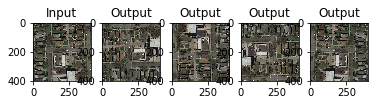

Extracting labels...


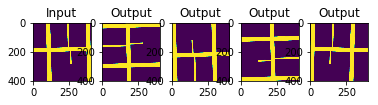

In [11]:
########### define directory of the training images ############################
data_dir = '../training/'
train_data_filename = data_dir + 'images/'
train_labels_filename = data_dir + 'groundtruth/'
TRAINING_SIZE = 5

data = extract_data(train_data_filename, TRAINING_SIZE, train=True)
labels = extract_labels(train_labels_filename, TRAINING_SIZE)

In [12]:
initial_data = data[range(0,data.shape[0],5)]
initial_labels = labels[range(0,data.shape[0],5)]

In [13]:
print(data.shape)
print(labels.shape)

(25, 400, 400, 3)
(25, 400, 400, 2)


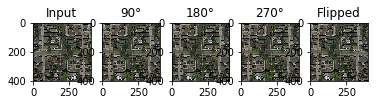

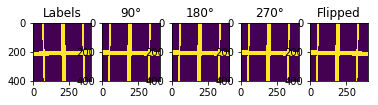

In [14]:
index = 0
plt.subplot(151),plt.imshow(data[5*index]),plt.title('Input')
plt.subplot(152),plt.imshow(data[5*index+1]),plt.title('90°')
plt.subplot(153),plt.imshow(data[5*index+1]),plt.title('180°')
plt.subplot(154),plt.imshow(data[5*index+1]),plt.title('270°')
plt.subplot(155),plt.imshow(data[5*index+1]),plt.title('Flipped')
plt.show()

plt.subplot(151),plt.imshow(labels[5*index,:,:,1]),plt.title('Labels')
plt.subplot(152),plt.imshow(labels[5*index+1,:,:,1]),plt.title('90°')
plt.subplot(153),plt.imshow(labels[5*index+1,:,:,1]),plt.title('180°')
plt.subplot(154),plt.imshow(labels[5*index+1,:,:,1]),plt.title('270°')
plt.subplot(155),plt.imshow(labels[5*index+1,:,:,1]),plt.title('Flipped')
plt.show()

In [15]:
net = unet.Unet(channels=3, n_class=2, layers=5, features_root=4) 
    #, cost_kwargs={'regularizer':1e-4}) # class_weights

2017-12-13 16:48:11,284 Layers 5, features 4, filter size 3x3, pool size: 2x2


In [16]:
# Optimizer = "momentum" or "adam"
trainer = unet.Trainer(net, batch_size=10, optimizer="adam")  # 20
    #, opt_kwargs=dict(momentum=0.2)), learning_rate, decay_rate

In [17]:
path = trainer.train(data=data, labels=labels, output_path="./unet_trained/"+saving_path, training_iters=5, \
                     epochs=2, dropout=1.0, display_step=5, prediction_path='prediction') # 20, 20

2017-12-13 16:48:48,860 Removing '/home/ondine/Documents/Cours/LMO_ML/project2/project_Ondine/unet/prediction'
2017-12-13 16:48:48,860 Removing '/home/ondine/Documents/Cours/LMO_ML/project2/project_Ondine/unet/unet_trained/trial1'
2017-12-13 16:48:48,861 Allocating '/home/ondine/Documents/Cours/LMO_ML/project2/project_Ondine/unet/prediction'
2017-12-13 16:48:48,862 Allocating '/home/ondine/Documents/Cours/LMO_ML/project2/project_Ondine/unet/unet_trained/trial1'


InvalidArgumentError: logits and labels must be same size: logits_size=[4000000,2] labels_size=[0,2]
	 [[Node: SoftmaxCrossEntropyWithLogits = SoftmaxCrossEntropyWithLogits[T=DT_FLOAT, _device="/job:localhost/replica:0/task:0/cpu:0"](Reshape_55, Reshape_56)]]

Caused by op 'SoftmaxCrossEntropyWithLogits', defined at:
  File "/home/ondine/anaconda3/lib/python3.6/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/home/ondine/anaconda3/lib/python3.6/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/home/ondine/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/home/ondine/anaconda3/lib/python3.6/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/home/ondine/anaconda3/lib/python3.6/site-packages/ipykernel/kernelapp.py", line 477, in start
    ioloop.IOLoop.instance().start()
  File "/home/ondine/anaconda3/lib/python3.6/site-packages/zmq/eventloop/ioloop.py", line 177, in start
    super(ZMQIOLoop, self).start()
  File "/home/ondine/anaconda3/lib/python3.6/site-packages/tornado/ioloop.py", line 888, in start
    handler_func(fd_obj, events)
  File "/home/ondine/anaconda3/lib/python3.6/site-packages/tornado/stack_context.py", line 277, in null_wrapper
    return fn(*args, **kwargs)
  File "/home/ondine/anaconda3/lib/python3.6/site-packages/zmq/eventloop/zmqstream.py", line 440, in _handle_events
    self._handle_recv()
  File "/home/ondine/anaconda3/lib/python3.6/site-packages/zmq/eventloop/zmqstream.py", line 472, in _handle_recv
    self._run_callback(callback, msg)
  File "/home/ondine/anaconda3/lib/python3.6/site-packages/zmq/eventloop/zmqstream.py", line 414, in _run_callback
    callback(*args, **kwargs)
  File "/home/ondine/anaconda3/lib/python3.6/site-packages/tornado/stack_context.py", line 277, in null_wrapper
    return fn(*args, **kwargs)
  File "/home/ondine/anaconda3/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 283, in dispatcher
    return self.dispatch_shell(stream, msg)
  File "/home/ondine/anaconda3/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 235, in dispatch_shell
    handler(stream, idents, msg)
  File "/home/ondine/anaconda3/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 399, in execute_request
    user_expressions, allow_stdin)
  File "/home/ondine/anaconda3/lib/python3.6/site-packages/ipykernel/ipkernel.py", line 196, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "/home/ondine/anaconda3/lib/python3.6/site-packages/ipykernel/zmqshell.py", line 533, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "/home/ondine/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2698, in run_cell
    interactivity=interactivity, compiler=compiler, result=result)
  File "/home/ondine/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2802, in run_ast_nodes
    if self.run_code(code, result):
  File "/home/ondine/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2862, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-15-cfa02490975e>", line 1, in <module>
    net = unet.Unet(channels=3, n_class=2, layers=5, features_root=4)
  File "/home/ondine/Documents/Cours/LMO_ML/project2/project_Ondine/unet/unet.py", line 190, in __init__
    self.cost = self._get_cost(logits, cost, cost_kwargs)
  File "/home/ondine/Documents/Cours/LMO_ML/project2/project_Ondine/unet/unet.py", line 228, in _get_cost
    labels=flat_labels))
  File "/home/ondine/anaconda3/lib/python3.6/site-packages/tensorflow/python/ops/nn_ops.py", line 1597, in softmax_cross_entropy_with_logits
    precise_logits, labels, name=name)
  File "/home/ondine/anaconda3/lib/python3.6/site-packages/tensorflow/python/ops/gen_nn_ops.py", line 2385, in _softmax_cross_entropy_with_logits
    features=features, labels=labels, name=name)
  File "/home/ondine/anaconda3/lib/python3.6/site-packages/tensorflow/python/framework/op_def_library.py", line 767, in apply_op
    op_def=op_def)
  File "/home/ondine/anaconda3/lib/python3.6/site-packages/tensorflow/python/framework/ops.py", line 2630, in create_op
    original_op=self._default_original_op, op_def=op_def)
  File "/home/ondine/anaconda3/lib/python3.6/site-packages/tensorflow/python/framework/ops.py", line 1204, in __init__
    self._traceback = self._graph._extract_stack()  # pylint: disable=protected-access

InvalidArgumentError (see above for traceback): logits and labels must be same size: logits_size=[4000000,2] labels_size=[0,2]
	 [[Node: SoftmaxCrossEntropyWithLogits = SoftmaxCrossEntropyWithLogits[T=DT_FLOAT, _device="/job:localhost/replica:0/task:0/cpu:0"](Reshape_55, Reshape_56)]]


In [ ]:
prediction = net.predict("./unet_trained/"+saving_path+"model.cpkt", initial_data)

In [ ]:
print(prediction.shape)

In [ ]:
print(initial_data.shape)

In [ ]:
id_end = 5
for num in range(0,id_end):
    fig, ax = plt.subplots(1, 3, sharex=True, sharey=True, figsize=(12,5))
    ax[0].imshow(initial_data[num])
    print(initial_data[num].shape)
    ax[1].imshow(initial_labels[num,:,:,1], aspect="auto")
    mask = prediction[num,:,:,1] > 0.5
    ax[2].imshow(mask, aspect="auto")
    #ax[2].imshow(prediction[num,:,:,1], aspect="auto")
    ax[0].set_title("Input")
    ax[1].set_title("Ground truth")
    ax[2].set_title("Prediction")
    fig.tight_layout()
    fig.savefig("output/roadSegmentation.png")

In [ ]:
train_data_dir = '../test_set_images/'
TESTING_SIZE = 5

test_data = extract_data(train_data_dir, TESTING_SIZE, train=False)
print(test_data.shape)

In [ ]:
for num in range(0,TESTING_SIZE):
    fig, ax = plt.subplots(1, 1, sharex=True, sharey=True, figsize=(6,6))
    ax.imshow(test_data[num], aspect="auto")
    ax.set_title("Input")
    fig.tight_layout()

In [ ]:
test_prediction = net.predict("./unet_trained/"+saving_path+"model.cpkt", test_data)

In [ ]:
print(test_data[num].shape)

In [ ]:
for num in range(0,TESTING_SIZE):
    fig, ax = plt.subplots(1, 2, sharex=True, sharey=True, figsize=(12,6))
    ax[0].imshow(test_data[num], aspect="auto")
    #mask = test_prediction[num,:,:,1] > 0.2
    #ax[1].imshow(mask, aspect="auto")
    ax[1].imshow(test_prediction[num,:,:,1], aspect="auto")
    ax[0].set_title("Input")
    ax[1].set_title("Prediction")
    fig.tight_layout()
    fig.savefig("output/roadSegmentation.png")